# Diffusion Model for Video Super Resolution

Inspiration gathered from:

https://github.com/CompVis/latent-diffusion

https://ar5iv.labs.arxiv.org/html/2311.15908

In [1]:
import torch as torch
import torchvision 
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
torchvision.__version__

'0.17.2+cu121'

In [3]:
# datasets with _sharp are the correct/ground truth images
# datasets with _blur_bicubic are those that have been blurred and
# downsampled using bicubic interpolation
datasets = ['train_sharp', 'train_blur_bicubic', 'val_sharp', 'val_blur_bicubic']
for set in datasets:
    print(set)
    if not os.path.isfile(f"REDS/{set}.zip"):
        # print("Downloading")
        cmdlet = f"python download_REDS.py --{set}"
        print(cmdlet)
        os.system(cmdlet)
# if not already downloaded, this will download all datasets (takes a while)
        

train_sharp
train_blur_bicubic
val_sharp
val_blur_bicubic


In [4]:
# Set up data into dataset and dataloader
# It assumes the project file structure as downloaded from above
# Built based on docs: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class REDS(Dataset):
    def __init__(self, train=True, device='cuda'):
        self.device = device
        self.type = 'train' if train else 'test' 
        if self.type == 'train':
            self.hr_dir = "REDS/train_sharp/train/train_sharp"
            self.lr_dir = "REDS/train_blur_bicubic/train/train_blur_bicubic/X4"
        else:
            self.hr_dir = "REDS/val_sharp/val/val_sharp"
            self.lr_dir = "REDS/val_blur_bicubic/val/val_blur_bicubic/X4"
            
    def __len__(self):
        return len(os.listdir(self.hr_dir)) # training size = 240 videos, testing size = 30 videos
            
    def __getitem__(self, idx):
        # each return gives a single HR frame with 5 corresponding LR frames
        # the middle LR frame (frame 3) will be the blurred/downsampled version of the HR frame
        # the 5 sequential LR frames will be chosen randomly from the given idx-video
        
        # Getting video sequence folder name
        if idx < 10:
            video = '00' + str(idx)
        elif idx < 100:
            video = '0' + str(idx)
        # Getting random sequence of 5 LR frames from the video    
        num_video_frames = len(os.listdir(f"{self.hr_dir}/000"))
        rand_frame_id = np.random.randint(2, num_video_frames - 2)
        lr_frame_idx = []
        for i in range(-2, 3):
            id_int = rand_frame_id + i
            if id_int < 10:
                id_str = '0000000' + str(id_int)
            elif id_int < 100:
                id_str = '000000' + str(id_int)
            else:
                id_str = '00000' + str(id_int)
            lr_frame_idx.append(id_str)
        # Actually reading in the images
        hr_frame = torchvision.io.read_image(f"{self.hr_dir}/{video}/{lr_frame_idx[2]}.png").to(self.device)
        lr_frames = []
        for v in lr_frame_idx:
            lr_frame = torchvision.io.read_image(f"{self.lr_dir}/{video}/{v}.png").to(self.device)
            lr_frames.append(lr_frame)
            
        return lr_frames, hr_frame

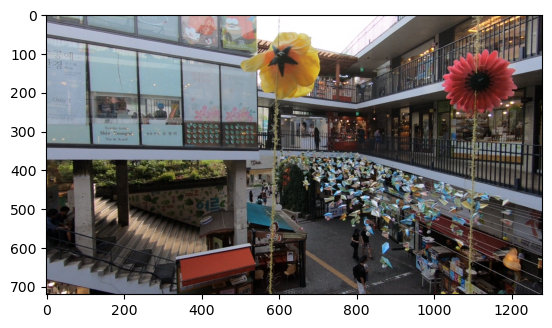

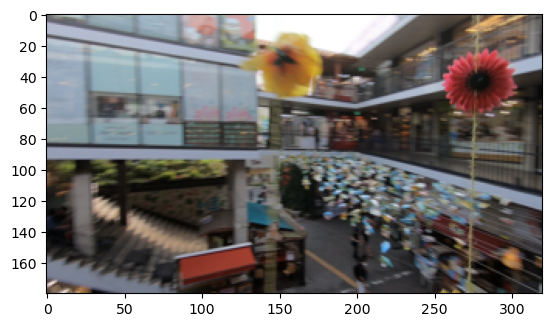

"\nif matplotlib doesn't run, go into the envs/pytorch_vsr environment in anaconda3\nand delete all version of libiomp5md.dll , and it should work\n"

In [5]:
train_dataset = REDS(train=True, device=device)
test_dataset = REDS(train=False, device=device)
# Using the customizable PyTorch dataset allows us to use dataloaders, iterable objects for training/testing that
# make it so easy!
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)
# Show an example of getting data from either of the datasets
# Top is high-res image, bottom is blurred/downsampled low-res image equivalent
lr_imgs, hr_img = train_dataset.__getitem__(25)
plt.imshow(hr_img.permute(1,2,0).cpu())
plt.show()
plt.imshow(lr_imgs[2].permute(1,2,0).cpu())
plt.show()
"""
if matplotlib doesn't run, go into the envs/pytorch_vsr environment in anaconda3
and delete all version of libiomp5md.dll , and it should work
"""

In [6]:
# Set up loss functions

# PSNR

# perceptual_loss
vgg = torchvision.models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1').features # removes final classification layer as we don't need it
vgg.to(device)
vgg.eval() # sets the model to evaluation mode, to not update weights
for param in vgg.parameters():
    param.requires_grad = False
def perceptual_loss(generated_img, target_img):
    
    return 

In [7]:
vgg(hr_img.float()).size()

torch.Size([512, 22, 40])

In [8]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [24]:
hr_img.size()

torch.Size([3, 720, 1280])